In [471]:
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.cluster import KMeans #import k-means clustering
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf

In [472]:
min_max_scaler = MinMaxScaler(feature_range=(1, 2))

def get_elbow_scores(data, max_num, min_num=1):
    avgs = pd.DataFrame(columns=['cluster_num', 'score'])

    for n in range(min_num,max_num+1):
        km_elbow = KMeans(n_clusters=n).fit(data) 
        centroids = [km_elbow.cluster_centers_]
        Dists_k = [cdist(data, cent, 'euclidean') for cent in centroids]

        dist = [np.min(D,axis=1) for D in Dists_k]
        avg = [sum(d)/data.shape[0] for d in dist]
        avgs = avgs.append({'cluster_num': n, 'score': avg[0]}, ignore_index=True)
    return avgs

def get_kmeans_labels(data, num_clusters):
    km = KMeans(n_clusters=num_clusters) 
    results=km.fit(data) 
    return results.labels_

def massage_original_data(data):
    data = data.sort_values(by=['price'])
    data = data[data['price'] != 'MISSING'] ## NOTE: filters out MISSING prices 
    data['price_cat'] = pd.factorize(data['price'])[0]+1
    ## $= under $10. $$=11-30. $$$=31-60. $$$$= over $61.
    data.loc[data['price'] == '$', 'price'] = 10
    data.loc[data['price'] == '$$', 'price'] = 20
    data.loc[data['price'] == '$$$', 'price'] = 45
    data.loc[data['price'] == '$$$$', 'price'] = 65
    return data

def normalize_data(data):
    data['review_cou']=(data['review_cou']-data['review_cou'].mean())/data['review_cou'].std()
    data['price_cat']=(data['price_cat']-data['price_cat'].mean())/data['price_cat'].std()
    return data

def do_elbow(data, columns, name, ticks=15):
    data_sub = data[columns].copy()
    data_std = normalize_data(data_sub)
    scores = get_elbow_scores(data_std, ticks)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title("Elbow Scores: {}".format(name), fontsize=18)
    ax.set_xlabel("Cluster Number")
    ax.set_ylabel("Avg Within SS")
    ax.plot(scores.cluster_num, scores.score,'r-') 
    
def do_kmeans(data, num_clusters, cols_analysis):
    data_sub = data[columns].copy()
    data_std = normalize_data(data_sub)
    labels = get_kmeans_labels(data_std, num_clusters)
    data['cluster'] = labels

    f, ax = plt.subplots(figsize=(10, 10))
    data.plot(ax=ax, column='cluster', legend=True)

    stats = data[cols_analysis].groupby(['cluster'], as_index=False).mean()
    stats['cluster'] = stats.index
    
    stats['review_cou_std']= min_max_scaler.fit_transform(stats['review_cou'].values.reshape(-1, 1)).reshape(1, -1)[0] #(stats['review_cou']-stats['review_cou'].mean())/stats['review_cou'].std()
    stats['rating_std']= min_max_scaler.fit_transform(stats['rating'].values.reshape(-1, 1)).reshape(1, -1)[0] #(stats['rating']-stats['rating'].mean())/stats['rating'].std()
    stats['price_std']= min_max_scaler.fit_transform(stats['price'].values.reshape(-1, 1)).reshape(1, -1)[0]#(stats['price']-stats['price'].mean())/stats['price'].std()
    stats['weight'] = stats['review_cou_std'] * stats['rating_std'] * stats['price_std']
    
    print(stats[['cluster','review_cou','rating','price','weight']])
    
    data = pd.merge(data, stats[['cluster','weight']], on='cluster', how='left')
    return data

def avg_clusters_by_NTA(data, NTA):
    temp = data[['weight','NTACode']].groupby(['NTACode'], as_index=False).mean()
    temp = temp.rename(columns={'weight': 'avg_weight'})
    temp = pd.merge(data, temp, on='NTACode', how='left')
    data_nta = pd.merge(temp, NTA, on='NTACode', how='left')
    data_nta['geometry'] = data_nta['geometry_y']
    return data_nta

def plot_map(data, column='avg_weight'):
    f, ax = plt.subplots(1, figsize=(12, 12))
    data.plot(ax=ax, column=column, legend=True )

In [473]:
# data paths
data_path = "./data"
Yelp_BK_path = data_path +  "/Yelp/BK/"
Yelp_MN_path = data_path + "/Yelp/MN/"
path_census_tracts = './data/ACS/CensusTracts'

In [474]:
columns = ['review_cou','rating', 'price_cat']
cols_analysis = ['cluster','review_cou','rating','price']

In [475]:
# Reading in Yelp shapefiles 
MN_Yelp = gpd.read_file(Yelp_MN_path + "MN_Yelp_CensusTract_NTA.shp")
BK_Yelp = gpd.read_file(Yelp_BK_path + "BK_Yelp_CensusTract_NTA.shp")
NY_Yelp = MN_Yelp.append([BK_Yelp], sort='True')

NTA = gpd.read_file('data/NTA/nynta.shp')

MN_Yelp = massage_original_data(MN_Yelp)
BK_Yelp = massage_original_data(BK_Yelp)
NY_Yelp = massage_original_data(NY_Yelp)

In [476]:
MN_Income = gpd.read_file('data/MN_NTA_income_dist_life_exp_price.csv')
BK_Income = gpd.read_file('data/BK_NTA_income_dist_life_exp_price.csv')
NY_Income = MN_Income.append([BK_Income], sort='True')

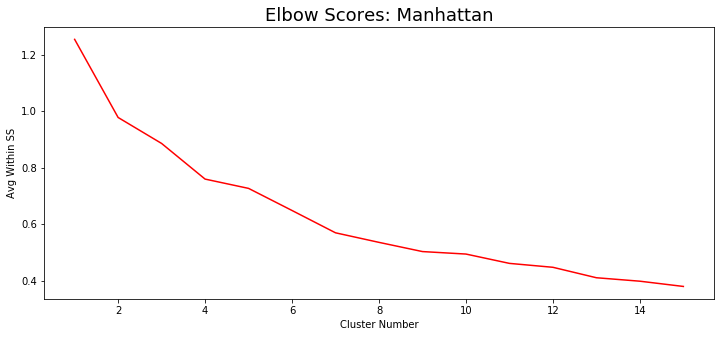

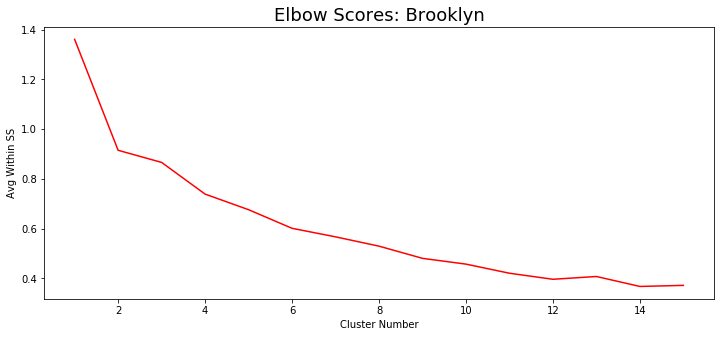

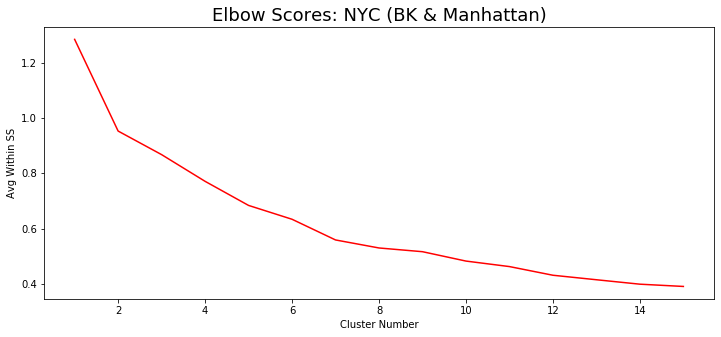

In [477]:
do_elbow(MN_Yelp, columns, 'Manhattan')

do_elbow(BK_Yelp, columns, 'Brooklyn')

do_elbow(NY_Yelp, columns, 'NYC (BK & Manhattan)')

   cluster   review_cou    rating      price    weight
0        0    31.167687  2.430845  10.563035  1.045806
1        1  1116.250000  3.887500  22.291667  7.863147
2        2    69.141026  3.939103  10.000000  2.069992
3        3   149.521612  3.735794  22.127246  4.109624


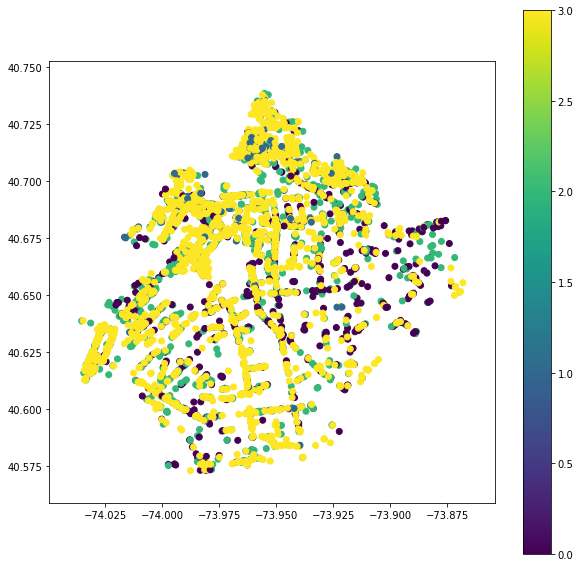

In [478]:
BK_Yelp_clustered = do_kmeans(BK_Yelp, 4, cols_analysis)

   cluster   review_cou    rating      price    weight
0        0   323.697238  3.777901  49.530387  3.928242
1        1   259.319812  3.591022  20.000000  1.919716
2        2  2049.665441  3.908088  24.816176  5.499219
3        3    96.564280  3.366762  10.000000  1.000000


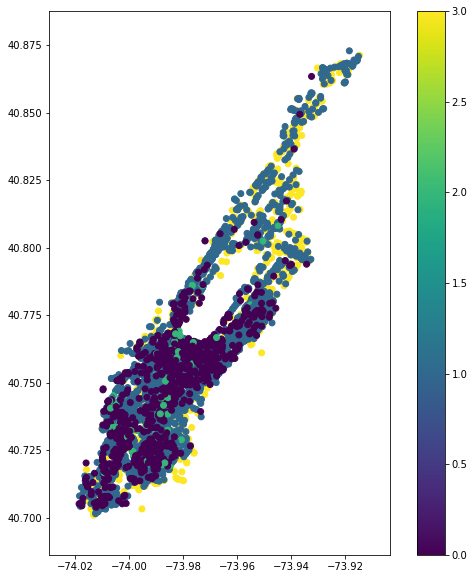

In [479]:
MN_Yelp_clustered = do_kmeans(MN_Yelp, 4, cols_analysis)

   cluster   review_cou    rating      price    weight
0        0   244.744299  3.747351  20.000000  2.597522
1        1    45.042166  2.467377  12.188194  1.055824
2        2   298.772388  3.768657  49.197761  4.274403
3        3  2032.321429  3.907468  24.610390  5.465465
4        4   102.612868  3.920956  10.000000  2.057939


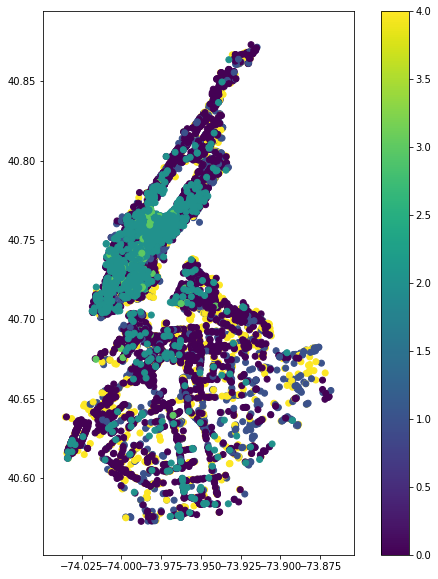

In [480]:
NY_Yelp_clustered = do_kmeans(NY_Yelp, 5, cols_analysis)

In [481]:
NY_NTA_Yelp = avg_clusters_by_NTA(NY_Yelp_clustered, NTA)
BK_NTA_Yelp = avg_clusters_by_NTA(BK_Yelp_clustered, NTA)
MN_NTA_Yelp = avg_clusters_by_NTA(MN_Yelp_clustered, NTA)

In [482]:
def run_regression(clustered_yelp_data, nta_income_data):
    NTA_Income_weight = pd.merge(nta_income_data, clustered_yelp_data[['NTACode','avg_weight']].drop_duplicates(), on='NTACode', how='left')
    NTA_Income_weight = NTA_Income_weight.sort_values(by=['avg_weight']) 
    
    for inc_pct in ['pct_0_25k', 'pct_25k_50k','pct_50k_75k','pct_75k_100k','pct_100k_125k','pct_125k_150k','pct_> 150k']:
        NTA_Income_weight[inc_pct] = NTA_Income_weight[inc_pct].astype(float)

    NTA_Income_weight['Low_Income'] = NTA_Income_weight['pct_0_25k'] + MN_Income_weight['pct_25k_50k']
    NTA_Income_weight['Mid_Income'] = NTA_Income_weight['pct_50k_75k'] + MN_Income_weight['pct_75k_100k']
    NTA_Income_weight['High_Income'] = NTA_Income_weight['pct_100k_125k'] + MN_Income_weight['pct_125k_150k'] + MN_Income_weight['pct_> 150k']

    print(NTA_Income_weight[['Low_Income', 'Mid_Income', 'High_Income', 'avg_weight']].corr(),"\n")
    print("\nIndividually")    
    for inc in ['Low_Income', 'Mid_Income', 'High_Income']:
        lm = smf.ols(formula = 'avg_weight ~ {}'.format(inc), data = NTA_Income_weight).fit()
        print("Income Level: {}, R2: {:.3f}, P-value: {:.3f}, Coef: {:.3f}".format(inc, lm.rsquared, lm.pvalues[1], lm.params[inc]))

    print("\nAll together")
    lm = smf.ols(formula = 'avg_weight ~ Low_Income + Mid_Income + High_Income', data = NTA_Income_weight).fit()
    idx = 1
    print("R2: {}".format(lm.rsquared))
    for inc in ['Low_Income', 'Mid_Income', 'High_Income']:
        print("Income Level: {}, P-value: {:.3f}, Coef: {:.3f}".format(inc, lm.pvalues[idx], lm.params[inc]))
        idx += 1


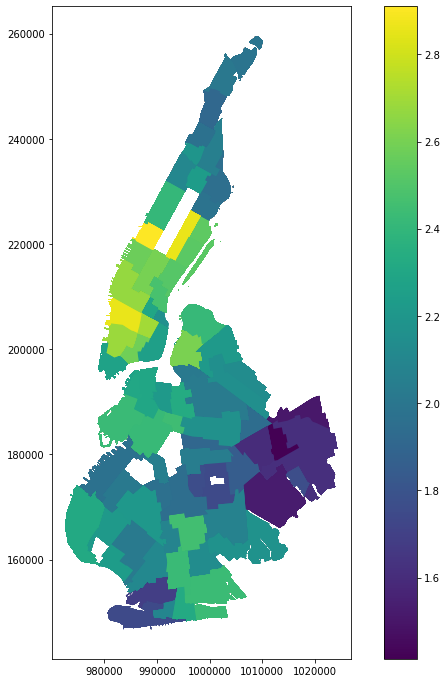

In [483]:
plot_map(NY_NTA_Yelp)

In [484]:
run_regression(NY_NTA_Yelp, NY_Income)

             Low_Income  Mid_Income  High_Income  avg_weight
Low_Income     1.000000    0.349854    -0.979966   -0.689737
Mid_Income     0.349854    1.000000    -0.526040   -0.522486
High_Income   -0.979966   -0.526040     1.000000    0.737360
avg_weight    -0.689737   -0.522486     0.737360    1.000000 


Individually
Income Level: Low_Income, R2: 0.476, P-value: 0.000, Coef: -1.237
Income Level: Mid_Income, R2: 0.273, P-value: 0.004, Coef: -4.094
Income Level: High_Income, R2: 0.544, P-value: 0.000, Coef: 1.195

All together
R2: 0.5711146020429528
Income Level: Low_Income, P-value: 0.719, Coef: 2.096
Income Level: Mid_Income, P-value: 0.915, Coef: 0.639
Income Level: High_Income, P-value: 0.591, Coef: 3.121


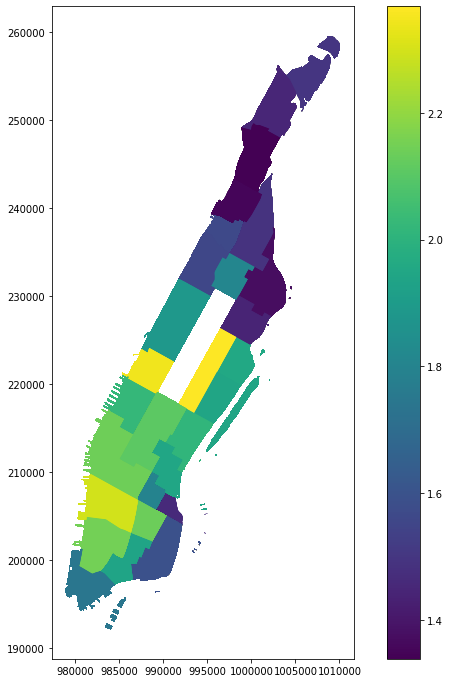

In [485]:
plot_map(MN_NTA_Yelp)

In [486]:
run_regression(MN_NTA_Yelp, MN_Income)

             Low_Income  Mid_Income  High_Income  avg_weight
Low_Income     1.000000    0.349854    -0.979966   -0.719649
Mid_Income     0.349854    1.000000    -0.526040   -0.516653
High_Income   -0.979966   -0.526040     1.000000    0.762286
avg_weight    -0.719649   -0.516653     0.762286    1.000000 


Individually
Income Level: Low_Income, R2: 0.518, P-value: 0.000, Coef: -1.356
Income Level: Mid_Income, R2: 0.267, P-value: 0.005, Coef: -4.252
Income Level: High_Income, R2: 0.581, P-value: 0.000, Coef: 1.298

All together
R2: 0.6000193673283837
Income Level: Low_Income, P-value: 0.872, Coef: 0.955
Income Level: Mid_Income, P-value: 0.952, Coef: -0.361
Income Level: High_Income, P-value: 0.721, Coef: 2.104


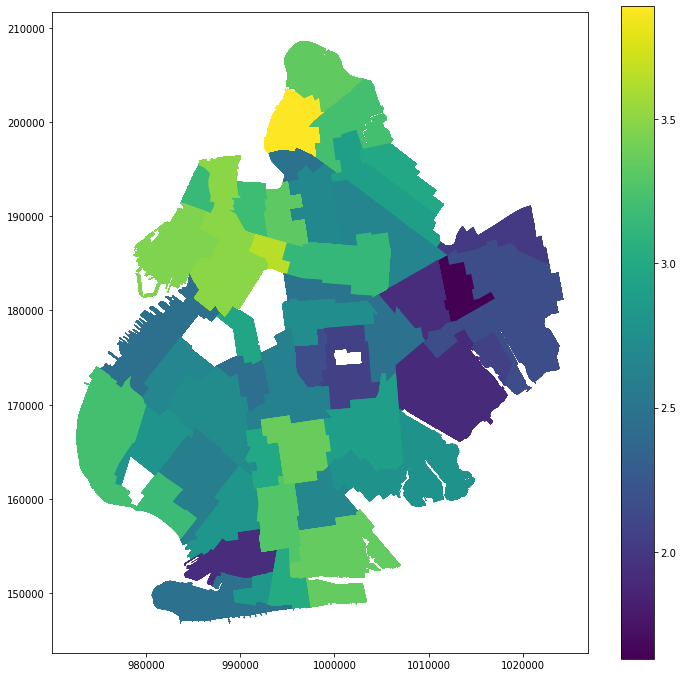

In [487]:
plot_map(BK_NTA_Yelp)

In [488]:
run_regression(BK_NTA_Yelp, BK_Income)

             Low_Income  Mid_Income  High_Income  avg_weight
Low_Income     1.000000   -0.399953    -0.652136   -0.297139
Mid_Income    -0.399953    1.000000     0.329422   -0.167271
High_Income   -0.652136    0.329422     1.000000   -0.091498
avg_weight    -0.297139   -0.167271    -0.091498    1.000000 


Individually
Income Level: Low_Income, R2: 0.088, P-value: 0.125, Coef: -1.491
Income Level: Mid_Income, R2: 0.028, P-value: 0.395, Coef: -2.723
Income Level: High_Income, R2: 0.008, P-value: 0.643, Coef: -0.255

All together
R2: 0.30627086044900775
Income Level: Low_Income, P-value: 0.005, Coef: -3.604
Income Level: Mid_Income, P-value: 0.117, Coef: -4.933
Income Level: High_Income, P-value: 0.052, Coef: -1.280
